In [19]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

# Select predictions file

In [20]:
for ppath in os.listdir('../../Downloads/'):
    if 'predictions' in ppath:
        print(ppath)

predictions_frame_5epoch_095009_02-08.npy
predictions_o_missingvids_minorimbalance_5epochs_224638_02-20.npy
predictions_s0.5_missingvids_minorimbalance_5epochs_230857_03-02.npy
predictions_s1_missingvids_minorimbalance_5epochs_152550_02-27.npy
predictions_s2_missingvids_minorimbalance_5epochs_181615_03-01.npy


In [21]:
# change this to a path to .npy file
path = '../../Downloads/predictions_o_missingvids_minorimbalance_5epochs_224638_02-20.npy'
preds = np.load(path)
preds, preds.shape

(array([['normal/01-GazeR_VD-10.jpg', '0.00061065954', '0.9993893'],
        ['normal/01-GazeR_VD-100.jpg', '0.8866811', '0.11331892'],
        ['normal/01-GazeR_VD-101.jpg', '0.050658993', '0.949341'],
        ...,
        ['nystagmus/24-Roll_L-97.jpg', '0.8134602', '0.18653981'],
        ['nystagmus/24-Roll_L-98.jpg', '0.87640595', '0.123594016'],
        ['nystagmus/24-Roll_L-99.jpg', '0.9981729', '0.0018271385']],
       dtype='<U33'),
 (79214, 3))

# Process individual filtered image predictions

In [22]:
probs_fi = np.array([float(p) for p in preds[:, 2]])
y_fi = np.array([int(float('nystagmus' in l)) for l in preds[:,0]])

fpr, tpr, thresh = roc_curve(y_fi, probs_fi, pos_label=1)
random_probs = [0 for i in range(len(y_fi))]
p_fpr, p_tpr, _ = roc_curve(y_fi, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y_fi, probs_fi)
print('AUC = ', auc_score1)

AUC =  0.8136437371312709


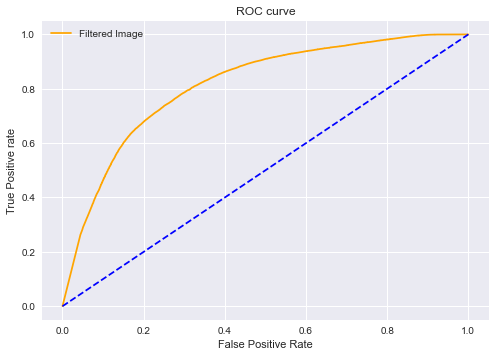

In [23]:
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr, tpr, linestyle='-',color='orange', label='Filtered Image')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

In [24]:
optimal_thresh = thresh[np.argmax(tpr-fpr)]
print('Optimal Threshold = ',round(optimal_thresh*100,2),'%')
optimal_thresh

Optimal Threshold =  32.49 %


0.32487783

# Process video level predictions

In [25]:
# this is a dictionary that stores predictions
# key = video name
# value = [count of filtered images above threshold, count of filtered images per video, true label of 0 or 1 (normal or nystagmus)]
vids_dict = dict()
for pred in preds:
    name = pred[0].split('/')[1].split('.')[0]
    name = name.split('-')[0] + name.split('-')[1]
    prob = float(pred[2])
    try:
        p, c, label = vids_dict[name]
        p += 1 if prob >= optimal_thresh else 0
        c += 1
        vids_dict[name] = (p, c, label)
    except:
        #p = prob
        p = 1 if prob >= optimal_thresh else 0
        c = 1
        label = int(float('nystagmus' in pred[0]))
        vids_dict[name] = (p,c,label)

In [26]:
# this function calculates a list of probabilities of nystagmus for each video
# vid_dict.keys(), y, probs are in same order (print to view)

y = []
probs = []
for key in vids_dict.keys():
    p, c, label = vids_dict[key]
    y.append(label)
    prob = float(p)/float(c)
    probs.append(prob)
y = np.array(y) # true labels
probs = np.array(probs) # predicted probabilities of nystagmus

# METRICS

In [27]:
fpr, tpr, thresh = roc_curve(y, probs, pos_label=1)
random_probs = [0 for i in range(len(y))]
p_fpr, p_tpr, _ = roc_curve(y, random_probs, pos_label=1)
auc_score1 = roc_auc_score(y, probs)
print('AUC = ', auc_score1)

AUC =  0.8531207598371777


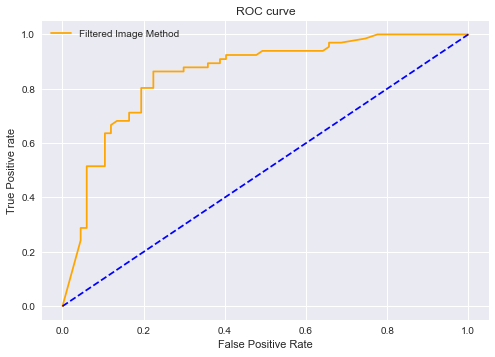

In [28]:
plt.style.use('seaborn')
# plot roc curves
plt.plot(fpr, tpr, linestyle='-',color='orange', label='Filtered Image Method')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('ROC',dpi=300)
plt.show();

In [29]:
optimal_thresh = thresh[np.argmax(tpr-fpr)]
print('Optimal Threshold = ',round(optimal_thresh*100,2),'%')

Optimal Threshold =  49.83 %


In [30]:
preds = np.array([int(float(p)) for p in (probs >= optimal_thresh)])

In [31]:
conf_matrix = confusion_matrix(y, preds)
print('Confusion Matrix')
conf_matrix

Confusion Matrix


array([[52, 15],
       [ 9, 57]], dtype=int64)

In [32]:
acc = accuracy_score(y, preds)
print('Accuracy = ', acc)

Accuracy =  0.8195488721804511


In [33]:
tn, fp, fn, tp = conf_matrix.ravel()
tn, fp, fn, tp

(52, 15, 9, 57)

In [34]:
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(fn+tn)

print('Sensitivity = ', sensitivity)
print('Specificity = ', specificity)
print('PPV = ', ppv)
print('NPV = ', npv)

Sensitivity =  0.8636363636363636
Specificity =  0.7761194029850746
PPV =  0.7916666666666666
NPV =  0.8524590163934426


In [46]:
sens = []
spec = []
ppvs = []
npvs = []
accs = []
ths = []
intersect_thresh = 0
for t,f,th in zip(tpr,fpr,thresh[1:]):
    try:
        preds_i = np.array([int(float(p)) for p in (probs >= th)])
        conf_matrix_i = confusion_matrix(y, preds_i)
        acc_i = accuracy_score(y, preds_i)
        tn, fp, fn, tp = conf_matrix_i.ravel()
        sensitivity = tp/(tp+fn)
        specificity = tn/(tn+fp)
        ppv = tp/(tp+fp)
        npv = tn/(fn+tn)
        if ppv == npv or npv == sensitivity or sensitivity==specificity or specificity==ppv: intersect_thresh=th
        sens.append(sensitivity)
        spec.append(specificity)
        ppvs.append(ppv)
        npvs.append(npv)
        accs.append(acc_i)
        ths.append(th)
    except:
        continue

<ipython-input-46-40d6815467e2>:17: RuntimeWarning: invalid value encountered in longlong_scalars
  npv = tn/(fn+tn)


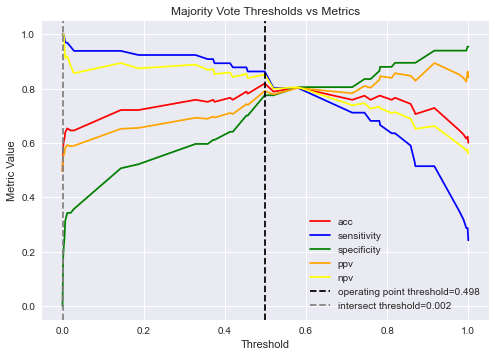

In [47]:
plt.plot(ths,accs, color='red', label='acc')
plt.plot(ths,sens, color='blue', label='sensitivity')
plt.plot(ths,spec, color='green', label='specificity')
plt.plot(ths,ppvs, color='orange', label='ppv')
plt.plot(ths,npvs, color='yellow', label='npv')
plt.axvline(x=optimal_thresh, label='operating point threshold='+str(round(optimal_thresh,3)), color='black', linestyle='--')
plt.axvline(x=intersect_thresh, label='intersect threshold='+str(round(intersect_thresh,3)), color='gray', linestyle='--')
plt.legend(loc='lower right')
plt.title('Majority Vote Thresholds vs Metrics')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.show()